In [198]:
import numpy as np
import torch
import torch.nn as nn
d_k = 64
d_v = 64

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    
    def forward(self, Q, K, V, attention_mask):
        #计算注意力得分
        scores = torch.matmul(Q, K.transpose(-1, -2)/np.sqrt(d_k))
        #注意力掩码，将attention_mask中值为1的位置替换为极小值
        scores.masked_fill_(attention_mask, -1e9)
        weights = nn.Softmax(dim=-1)(scores)
        #根据注意力计算带关注度的上下文向量
        context = torch.matmul(weights, V)
        return context, weights


In [199]:
#定义多头注意力
d_embedding = 512
n_heads = 8
batch_size = 3
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_embedding, d_k*n_heads)
        self.W_K = nn.Linear(d_embedding, d_k*n_heads)
        self.W_V = nn.Linear(d_embedding, d_k*n_heads)
        self.linear = nn.Linear(d_k*n_heads, d_embedding)
        self.layer_norm = nn.LayerNorm(d_embedding)
    
    def forward(self, Q, K, V, attn_mask):
        residual, batch_size = Q, Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1, 2)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        context, weights = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads*d_v)
        output = self.linear(context)
        output = self.layer_norm(output + residual)
        return output, weights

print(MultiHeadAttention())

MultiHeadAttention(
  (W_Q): Linear(in_features=512, out_features=512, bias=True)
  (W_K): Linear(in_features=512, out_features=512, bias=True)
  (W_V): Linear(in_features=512, out_features=512, bias=True)
  (linear): Linear(in_features=512, out_features=512, bias=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


In [200]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_ff=2048):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_embedding, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_embedding, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_embedding)
    
    def forward(self, inputs):
        residual = inputs
        output = nn.ReLU()(self.conv1(inputs.transpose(1,2)))
        output = self.conv2(output).transpose(1,2)
        output = self.layer_norm(output + residual)
        return output
    
    


In [201]:
#定义正弦位置编码函数，用于向Transfomer引入位置编码
def get_sin_enc_table(n_position, embedding_dim):
    sinusoid_table = np.zeros((n_position, embedding_dim))
    for pos_i in range(n_position):
        for hid_j in range(embedding_dim):
            angle = pos_i / np.power(10000, 2*(hid_j // 2) / embedding_dim)
            sinusoid_table[pos_i, hid_j]=angle
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.FloatTensor(sinusoid_table)

In [202]:
#定义填充注意力掩码函数
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k)
    return pad_attn_mask


In [203]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outpus, attn_weights = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_output = self.pos_ffn(enc_outpus)
        return enc_outpus, attn_weights

In [204]:
#定义编码器
n_layers = 6
class Encoder(nn.Module):
    def __init__(self, corpus):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(len(corpus.src_vocab), d_embedding)
        self.pos_emb = nn.Embedding.from_pretrained(get_sin_enc_table(corpus.src_len+1, d_embedding), freeze=True)
        self.layers = nn.ModuleList(EncoderLayer() for _ in range(n_layers))

    def forward(self, enc_inputs):
        pos_indices = torch.arange(1, enc_inputs.size(1) + 1).unsqueeze(0).to(enc_inputs)
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(pos_indices)
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attn_weights = []
        for layer in self.layers:
            enc_outputs, enc_self_attn_weight = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attn_weights.append(enc_self_attn_weight)
        return enc_outputs, enc_self_attn_weights
    



In [205]:
def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask


In [206]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn
    

In [207]:
#定义解码器
n_layers = 6
class Decoder(nn.Module):
    def __init__(self, corpus):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(len(corpus.tgt_vocab), d_embedding)
        self.pos_emb = nn.Embedding.from_pretrained(get_sin_enc_table(corpus.tgt_len+1, d_embedding), freeze=True)
        self.layers = nn.ModuleList(DecoderLayer() for _ in range(n_layers))

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        pos_indices = torch.arange(1, dec_inputs.size(1) + 1).unsqueeze(0).to(dec_inputs)
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(pos_indices)
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)
        dec_self_attns, dec_enc_attns = [], []
        for layers in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layers(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

In [208]:
class Transformer(nn.Module):
    def __init__(self, corpus):
        super(Transformer, self).__init__()
        self.encoder = Encoder(corpus)
        self.decoder = Decoder(corpus)
        self.projection = nn.Linear(d_embedding, len(corpus.tgt_vocab), bias=False)

    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs)
        return dec_logits, enc_self_attns, dec_self_attns, dec_enc_attns

In [209]:
sentences = [['项羽 爱 虞姬', 'Xiangyu loves Yuji'],
             ['我 爱 学习 人工智能', 'I love studying AI'],
             ['深度学习 改变 世界', 'DL changed the world'],
             ['自然语言处理 很 强大', 'NLP is so powerful'],
             ['神经网络 非常 复杂', 'Neural-Nets are complex']]

from collections import Counter
class TranslationCorpus:
    def __init__(self, sentences):
        self.sentences = sentences
        self.src_len = max(len(sentence[0].split()) for sentence in sentences) + 1
        self.tgt_len = max(len(sentence[1].split()) for sentence in sentences) + 2
        self.src_vocab, self.tgt_vocab = self.create_vocabularies()
        self.src_idx2word = {v: k for k, v in self.src_vocab.items()}
        self.tgt_idx2word = {v: k for k, v in self.tgt_vocab.items()}

    def create_vocabularies(self):
        src_counter = Counter(word for sentence in self.sentences for word in sentence[0].split())
        tgt_counter = Counter(word for sentence in self.sentences for word in sentence[1].split())
        src_vocab = {'<pad>': 0, **{word: i+1 for i, word in enumerate(src_counter)}}
        tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, **{word: i+3 for i, word in enumerate(tgt_counter)}}
        return src_vocab, tgt_vocab

    def make_batch(self, batch_size, test_batch=False):
        input_batch, output_batch, target_batch = [], [], []
        sentence_indices = torch.randperm(len(self.sentences))[:batch_size]
        for index in sentence_indices:
            src_sentence, tgt_sentence = self.sentences[index]
            src_seq = [self.src_vocab[word] for word in src_sentence.split()]
            tgt_seq = [self.tgt_vocab['<sos>']] + [self.tgt_vocab[word] for word in tgt_sentence.split()] + [self.tgt_vocab['<eos>']]
            src_seq += [self.src_vocab['<pad>']]*(self.src_len - len(src_seq))
            tgt_seq += [self.tgt_vocab['<pad>']]*(self.tgt_len - len(tgt_seq))
            input_batch.append(src_seq)
            output_batch.append([self.tgt_vocab['<sos>']] + ([self.tgt_vocab['<pad>']]*(self.tgt_len - 2)) if test_batch else tgt_seq[:-1])
            target_batch.append(tgt_seq[1:])
            
        input_batch = torch.LongTensor(input_batch)
        output_batch = torch.LongTensor(output_batch)
        target_batch = torch.LongTensor(target_batch)
        return input_batch, output_batch, target_batch

corpus = TranslationCorpus(sentences)

Epoch: 0001, cost=3.252170
Epoch: 0002, cost=3.095895
Epoch: 0003, cost=1.691392
Epoch: 0004, cost=0.821740
Epoch: 0005, cost=1.270819


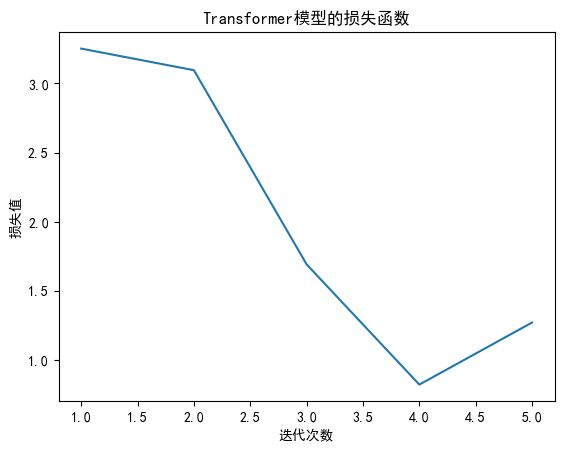

In [210]:
import torch
import torch.optim as optim
model = Transformer(corpus)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 5
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size)
    outputs, _, _, _ = model(enc_inputs, dec_inputs)
    loss = criterion(outputs.view(-1, len(corpus.tgt_vocab)), target_batch.view(-1))
    if (epoch+1)%1 == 0:
        print(f'Epoch: {epoch+1:04d}, cost={loss:.6f}')
        losses.append(loss.item())
    loss.backward()
    optimizer.step()

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(range(1, 6), losses)
plt.title('Transformer模型的损失函数')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.show()

In [212]:
enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size=1, test_batch=True)
predict, enc_self_attn, dec_self_attn, dec_enc_attn = model(enc_inputs, dec_inputs)
predict = predict.view(-1, len(corpus.tgt_vocab))
predict = predict.data.max(1, keepdim=True)[1]
print(predict)
translated_sentence = [corpus.tgt_idx2word[idx.item()] for idx in predict.squeeze()]
input_sentence = ''.join([corpus.src_idx2word[idx.item()] for idx in enc_inputs[0]])
print(input_sentence, '->', translated_sentence)

tensor([[3],
        [3],
        [3],
        [3],
        [3]])
项羽爱虞姬<pad><pad> -> ['Xiangyu', 'Xiangyu', 'Xiangyu', 'Xiangyu', 'Xiangyu']


In [216]:
def greedy_decoder(model, enc_inputs, start_symbol):
    enc_outputs, enc_self_attn = model.encoder(enc_inputs)
    dec_input = torch.zeros(1, 5).type_as(enc_inputs.data)
    next_symbol = start_symbol
    for i in range(0,5):
        dec_input[0][i] = next_symbol
        dec_output, _, _ = model.decoder(dec_input, enc_inputs, enc_outputs)
        projected = model.projection(dec_output)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()
    dec_outputs = dec_input
    return dec_outputs

In [217]:
enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size=1, test_batch=True)
greedy_dec_input = greedy_decoder(model, enc_inputs, start_symbol=corpus.tgt_vocab['<sos>'])
greedy_dec_output_words = [corpus.tgt_idx2word[n.item()] for n in greedy_dec_input.squeeze()]
enc_inputs_words = [corpus.src_idx2word[code.item()] for code in enc_inputs[0]]
print(enc_inputs_words, '->', greedy_dec_output_words)

['深度学习', '改变', '世界', '<pad>', '<pad>'] -> ['<sos>', 'DL', 'changed', 'the', 'world']
